# Setup & Import


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
import json
import os
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import forestci as fci
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import threading
from sklearn.metrics import make_scorer
import dash
from dash import dcc, html
import plotly.graph_objects as go
from dash.dependencies import Input, Output
import webbrowser
from threading import Timer
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.utils.parallel import Parallel, delayed
from sklearn.utils.validation import (
    check_is_fitted,
)
from sklearn.ensemble._base import _partition_estimators

pio.renderers.default = "browser"  # render plotly figures in browser

PARENT_DATA_DIR = os.getenv('PARENT_DATA_DIR')
if PARENT_DATA_DIR is None:
    raise ValueError("PARENT_DATA_DIR environment variable is not set")


dataDirpath = PARENT_DATA_DIR + r"\PRiOT\dataExport_1"  # "/Applications/Documents/TM Maxime/dataExport_3400_daily"#
dataCacheDirpath = os.path.join(dataDirpath, "cache")
logsDirpath = "../logs"
useCached = False
forceTrain = True
tuneMaxProductionEstimators = True
random_state = 42

minTrainingDays = 30
testingDays = 100

if not os.path.exists(logsDirpath):
    os.makedirs(logsDirpath)

if not os.path.exists(dataCacheDirpath):
    os.makedirs(dataCacheDirpath)

# Serializer


In [97]:
# https://scikit-learn.org/stable/model_persistence.html


class ModelSerializer:
    def _save_model(self, model, serial_type, save_params):
        serial_type.dump(model, save_params)

    def _retrieve_model(self, serial_type, retrieve_params):
        return serial_type.load(retrieve_params)


# save_model_path = "Serialized_models\\"


class JoblibSerializer(ModelSerializer):
    def save_model(self, model, save_model_path, filename):
        super()._save_model(model, joblib, os.path.join(save_model_path, filename + ".joblib"))

    def retrieve_model(self, save_model_path, filename):
        return super()._retrieve_model(joblib, os.path.join(save_model_path, filename + '.joblib'))


class PickleSerializer(ModelSerializer):
    def save_model(self, model, save_model_path, filename):
        with open(os.path.join(save_model_path, filename + ".pkl"), 'wb') as f:
            super()._save_model(model, pickle, f)

    def retrieve_model(self, save_model_path, filename):
        with open(os.path.join(save_model_path, filename + ".pkl"), 'rb') as f:
            return super()._retrieve_model(pickle, f)

# Function


In [98]:
def get_altitude_from_wgs84(longitude, latitude):
    # Convert WGS84 to LV95
    lv95_url = "https://geodesy.geo.admin.ch/reframe/wgs84tolv95"
    params_lv95 = {
        "easting": longitude,
        "northing": latitude,
        "format": "json"
    }

    response_lv95 = requests.get(lv95_url, params=params_lv95)
    if response_lv95.status_code != 200:
        raise Exception("Error converting WGS84 to LV95: " + response_lv95.text)

    lv95_data = response_lv95.json()
    lv95_easting = lv95_data["easting"]
    lv95_northing = lv95_data["northing"]

    # Get altitude from LV95 coordinates
    altitude_url = "https://api3.geo.admin.ch/rest/services/height"
    params_altitude = {
        "easting": lv95_easting,
        "northing": lv95_northing
    }

    response_altitude = requests.get(altitude_url, params=params_altitude)
    if response_altitude.status_code != 200:
        raise Exception("Error retrieving altitude: " + response_altitude.text)

    altitude_data = response_altitude.json()
    altitude = altitude_data["height"]

    return float(altitude)

def remove_system(systemName, message):
    if 'systemsName_Valid' in globals() and systemName in systemsName_Valid:
        systemsName_Valid.remove(systemName)
    if 'systemsName_Target' in globals() and systemName in systemsName_Target:
        systemsName_Target.remove(systemName)
    if 'systemsData_EstimatedMaxDailyEnergy' in globals() and systemName in systemsData_EstimatedMaxDailyEnergy.columns:
        systemsData_EstimatedMaxDailyEnergy.drop(columns=systemName, inplace=True)
    if 'systemsData_MeasuredDailyEnergy_train' in globals() and systemName in systemsData_MeasuredDailyEnergy_train.columns:
        systemsData_MeasuredDailyEnergy_train.drop(columns=systemName, inplace=True)
    print(message)

## Import metadata


In [99]:
metadataFilepath = os.path.join(dataDirpath, "metadata.json")

with open(metadataFilepath, 'r') as f:
    systemsMetadata = json.load(f)

# Add altitude to metadata, if not already present (TODO : imporove with multi threading)

for systemId, systemMetadata in tqdm(systemsMetadata.items()):
    if "loc_altitude" not in systemMetadata['metadata']:
        if "loc_longitude" in systemMetadata['metadata'] and "loc_latitude" in systemMetadata['metadata']:
            systemMetadata['metadata']["loc_altitude"] = get_altitude_from_wgs84(systemMetadata['metadata']["loc_longitude"], systemMetadata['metadata']["loc_latitude"])

# Split arrays in dictionaries by module number
for systemId, systemMetadata in systemsMetadata.items():
    arrays = {}
    keys_to_delete = []
    for key, value in systemMetadata['metadata'].items():
        if 'mod' in key:
            # Extract the module number
            array_num = key.split('_')[1][-1]
            # Remove the module number from the key
            new_key = '_'.join(key.split('_')[:1] + key.split('_')[2:])
            # Add the key-value pair to the appropriate module dictionary
            if 'arrays' not in systemMetadata:
                systemMetadata['arrays'] = {}
            if array_num not in systemMetadata['arrays']:
                systemMetadata['arrays'][array_num] = {}
            systemMetadata['arrays'][array_num][new_key] = value
            keys_to_delete.append(key)
    for key in keys_to_delete:
        del systemMetadata['metadata'][key]

# Save metadata with altitude
with open(metadataFilepath, 'w') as f:
    json.dump(systemsMetadata, f, indent=4)

100%|██████████| 63/63 [00:00<?, ?it/s]

## Import measures


In [100]:
cacheFilename_systemsData_MeasuredDailyEnergy = os.path.join(dataCacheDirpath, 'systemsData_MeasuredDailyEnergy.pkl')
if useCached and os.path.exists(cacheFilename_systemsData_MeasuredDailyEnergy):
    print(f"Loading cached data in {cacheFilename_systemsData_MeasuredDailyEnergy}")
    systemsData_MeasuredDailyEnergy = pd.read_pickle(cacheFilename_systemsData_MeasuredDailyEnergy)
    systemsName_Valid = systemsData_MeasuredDailyEnergy.columns
else:
    # Load all csv files from the data directory
    systemsData = {}
    for file in os.listdir(dataDirpath):
        if file.endswith(".csv"):
            systemName = file.split("_")[0]
            systemsData[systemName] = pd.read_csv(os.path.join(dataDirpath, file))
            systemsData[systemName]['Datetime'] = pd.to_datetime(systemsData[systemName]['Timestamp'], unit='ms', utc=True).dt.tz_convert('Europe/Zurich')
            systemsData[systemName]['Date'] = (systemsData[systemName]['Datetime'] + pd.Timedelta(hours=1)).dt.date  # Convert the datetime to only the date, as the production is the daily production. The +1h is to manage the saving time. Normally PRiOT exports the data at midnight (local time) for the day after (e.g. the energy for the July 1st is saved at July 1st 00:00 Europe/Zurich). However it seams that the saving time is not always correctly handled, and sometime the export is done at 23:00 the day before (e.g. the energy for the July 1st is saved at June 30th 23:00 Europe/Zurich). This is why we add 1h to the datetime to be sure to have the correct date.

    systemsName = list(systemsData.keys())

    df_duplicate_list = list()
    for systemName, systemData in systemsData.items():
        # Save duplicate dates to log list, and the in a log file
        duplicates = systemData[systemData['Date'].duplicated(keep=False)]
        if len(duplicates) > 0:
            df_duplicate_list.append(duplicates)

            # Remove duplicate date where tt_forward_active_energy_total_toDay is the smallest
            # TODO maybe we should sum the energy of the duplicates instead of removing the smallest one. However, when looking in PRiOT Portal, it seams that in the daily energy, only the biggest value is represented. We do the same here.
            systemData.sort_values('tt_forward_active_energy_total_toDay', ascending=True, inplace=True)
            systemsData[systemName].drop_duplicates(subset='Date', keep='last', inplace=True)

        # Set date as the index and sort the data by date
        systemsData[systemName].set_index('Date', inplace=True)
        systemData.sort_index(ascending=True, inplace=True)

    # Save duplicate dates to log file
    df_duplicate = pd.concat(df_duplicate_list)
    print(f"Number of duplicate dates found: {len(df_duplicate)} (see log file for more details)")
    df_duplicate.to_csv(os.path.join(logsDirpath, 'duplicateDates.csv'), index=True)

    ## ----------------------------------------------- ##
    ## Convert data & Filter out invalid PRiOT systems ##
    ## ----------------------------------------------- ##

    systemsName_Valid = systemsName.copy()
    for systemName in systemsName:
        missingData = False
        # Check if the system has measures
        if len(systemsData[systemName]) == 0:
            missingData = True
            print(f"System {systemName} : No measures found")
        # Check if the system has metadata
        if systemName not in systemsMetadata:
            missingData = True
            print(f"System {systemName} : No metadata found")

        else:
            # Check metadata for the system
            for key in ['loc_latitude', 'loc_longitude', 'loc_altitude', 'pv_kwp']:
                # test that the key is present
                if key not in systemsMetadata[systemName]['metadata']:
                    missingData = True
                    print(f"System {systemName} : No '{key}' found")
                # if present, convert the value to a number, if possible
                elif not isinstance(systemsMetadata[systemName]['metadata'][key], (int, float)):
                    try:
                        systemsMetadata[systemName]['metadata'][key] = int(systemsMetadata[systemName]['metadata'][key])
                    except ValueError:
                        try:
                            systemsMetadata[systemName]['metadata'][key] = float(systemsMetadata[systemName]['metadata'][key])
                        except ValueError:
                            missingData = True
                            print(f"System {systemName} : The key-value '{key}:{systemsMetadata[systemName]['metadata'][key]}' is not a number")

            # Check metadata for the arrays
            if 'arrays' not in systemsMetadata[systemName] or len(systemsMetadata[systemName]['arrays']) == 0:
                print(f"System {systemName} : No PV arrays found")
                missingData = True
            else:
                for array_num, arrayData in systemsMetadata[systemName]['arrays'].items():
                    for key in ['pv_tilt', 'pv_azimut', 'pv_wp', 'pv_number']:
                        if key not in arrayData:
                            missingData = True
                            print(f"System {systemName} : No '{key}' found for array {array_num}")
                        # test that the value is a number
                        elif not isinstance(arrayData[key], (int, float)):
                            try:
                                arrayData[key] = int(arrayData[key])
                            except ValueError:
                                try:
                                    arrayData[key] = float(arrayData[key])
                                except ValueError:
                                    missingData = True
                                    print(f"System {systemName} : The key-value '{key}:{arrayData[key]}' is not a number for array {array_num}")

            # add the loss metadata if not present
            if 'loss' not in systemsMetadata[systemName]['metadata']:
                systemsMetadata[systemName]['metadata']['loss'] = 0

        if missingData:
            systemsName_Valid.remove(systemName)
            print(f"-> Removing system {systemName} from the list of systems")

    print(f"Number of systems with all the necessary data: {len(systemsName_Valid)}/{len(systemsName)}")

    # # Filter out systems with less than X days of data
    # for systemName in systemsName_Valid[:]:  # Create a copy of the list using slicing [:] to avoid removing elements while iterating over the list itself
    #     if len(systemsData[systemName]) < minMeasurements:
    #         systemsName_Valid.remove(systemName)
    #         print(f"-> Removing system {systemName} from the list of systems because it has less than {minMeasurements} days of data")

    # print(f"Number of systems with at least {minMeasurements} days of data: {len(systemsName_Valid)}/{len(systemsName)}")

    ## ---------------------------------------------------------------------------- ##
    ## Create one 2D DataFrame with the daily production of every remaining systems ##
    ## ---------------------------------------------------------------------------- ##

    # Create an empty list to store all measured data for each systems
    systemsData_MeasuredDailyEnergy_List = []

    # Iterate over each key-value pair in the systemsData dictionary
    for systemName in systemsName_Valid:
        # Extract the 'tt_forward_active_energy_total_toDay' column from the current dataframe
        measuredDailyEnergy = systemsData[systemName]['tt_forward_active_energy_total_toDay']

        # Rename the column with the system name
        measuredDailyEnergy.rename(systemName, inplace=True)

        systemsData_MeasuredDailyEnergy_List.append(measuredDailyEnergy)
        # Concatenate the column to the new_dataframe

    # Concatenate all the columns in the list to create one dataframe
    systemsData_MeasuredDailyEnergy = pd.concat(systemsData_MeasuredDailyEnergy_List, axis=1)
    systemsData_MeasuredDailyEnergy.index = pd.to_datetime(systemsData_MeasuredDailyEnergy.index)
    systemsData_MeasuredDailyEnergy.sort_index(inplace=True)

    ## ------------------ ##
    ## Save the dataframe ##
    ## ------------------ ##
    # Save the dataframe for later use
    # create cache directory if it does not exist

    systemsData_MeasuredDailyEnergy.to_pickle(cacheFilename_systemsData_MeasuredDailyEnergy)

# Print the dataframe
systemsData_MeasuredDailyEnergy

Number of duplicate dates found: 142 (see log file for more details)
System a001116 : No 'pv_wp' found for array 2
-> Removing system a001116 from the list of systems
System a001164 : No measures found
-> Removing system a001164 from the list of systems
System a001383 : No 'pv_tilt' found for array 1
System a001383 : No 'pv_tilt' found for array 2
-> Removing system a001383 from the list of systems
System a001407 : No 'pv_tilt' found for array 1
-> Removing system a001407 from the list of systems
System a001426 : No 'pv_tilt' found for array 1
-> Removing system a001426 from the list of systems
System a001477 : The key-value 'pv_azimut:141 / 321' is not a number for array 1
-> Removing system a001477 from the list of systems
System a001539 : The key-value 'pv_azimut:West: 293Â° / Ost: 113Â°' is not a number for array 1
-> Removing system a001539 from the list of systems
System a001566 : The key-value 'pv_azimut:61/241' is not a number for array 1
-> Removing system a001566 from the lis

,a001035,a001036,a001096,a001099,a001131,a001138,a001155,a001159,a001163,a001190,...,a001464,a001473,a001487,a001494,a001513,a001542,a001553,a001584,a001633,a001634
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,14.8,284.4,8.3,10.3,9.2,31.4,19.2,2.8,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,25.7,342.8,8.9,11.8,14.5,41.7,33.1,3.5,9.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,15.8,272.0,7.4,7.6,8.4,29.0,20.3,4.2,8.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,2.1,86.5,2.2,2.0,1.3,5.1,3.6,1.3,1.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,6.0,196.7,5.8,4.9,3.9,12.5,10.1,2.3,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,NaN,670.9,16.8,NaN,11.0,29.2,31.9,7.7,15.9,8.7,...,98.27,14.24,13.56,13.67,61.9,21.8,NaN,27.9,46.0,NaN
2024-04-19,NaN,453.3,13.6,NaN,8.6,29.5,21.7,5.3,11.5,6.7,...,68.50,7.31,8.64,15.17,46.4,11.9,26.47,18.9,20.5,27.03
2024-04-20,NaN,1007.7,29.9,NaN,20.2,68.4,48.3,9.4,28.4,16.5,...,153.63,12.00,19.33,32.97,NaN,29.7,53.42,43.7,48.6,55.41


## Choose system to train


In [101]:
systemsName_Target = systemsName_Valid.copy()
# systemsName_Target = ["a001464"]

## Create test set


In [102]:
# create a validation set with the last 100 days
# if testingDays == 0:
#     systemsData_MeasuredDailyEnergy_train = systemsData_MeasuredDailyEnergy
#     systemsData_MeasuredDailyEnergy_val = pd.DataFrame()
# else:
if testingDays > len(systemsData_MeasuredDailyEnergy):
    raise ValueError(f"testingDays ({testingDays}) is greater than the number of days in the dataset ({len(systemsData_MeasuredDailyEnergy)})")
systemsData_MeasuredDailyEnergy_train, systemsData_MeasuredDailyEnergy_val = train_test_split(systemsData_MeasuredDailyEnergy, test_size=testingDays, random_state=42, shuffle=False)



In [103]:
for systemName in systemsData_MeasuredDailyEnergy_train.loc[:,systemsData_MeasuredDailyEnergy_train.notnull().sum()<minTrainingDays].columns:
    remove_system(systemName, f"System {systemName} : Not enough days for training (min {minTrainingDays} days required)")


System a001513 : Not enough days for training (min 30 days required)
System a001542 : Not enough days for training (min 30 days required)
System a001553 : Not enough days for training (min 30 days required)
System a001584 : Not enough days for training (min 30 days required)
System a001633 : Not enough days for training (min 30 days required)
System a001634 : Not enough days for training (min 30 days required)


## Max production estimator


### Functions


In [104]:
# Convert the power production with a given frequency to the total daily energy
def daily_energy(df_power):
    # Get the frequency in minutes
    freq_in_minutes = pd.Timedelta(df_power.index.freq).seconds / 60
    # Convert power from kW to kWh
    df_energy = df_power * (freq_in_minutes / 60)
    # Resample to daily frequency and sum the values
    daily_energy = df_energy.resample('D').sum()
    # daily_energy.index = daily_energy.index.date

    return daily_energy

# Simulate the daily production of a system from a start date to an end date using the given PVLib ModelChain


def generate_max_production_estimate(startDate, endDate, estimator: ModelChain, samplingFreq='1h'):
    # The end date needs to be estimated completly(end date at 23:59). But "endDate" is considered as 00:00 by pd.date_range().
    # So we add 1 day to the end date to include the entire end date in the date_range(), and then we exclude the last value with the inclusive='left' proprety, to remove "endDate+1" at 00:00) in the date_range().
    endDate = endDate + pd.Timedelta(days=1)

    times = pd.date_range(start=startDate, end=endDate, freq=samplingFreq, tz=estimator.location.tz, inclusive='left')
    weatherClearSky = estimator.location.get_clearsky(times)  # In W/m2
    # TODO adjust the clear sky model to take into account the horizon https://pvlib-python.readthedocs.io/en/stable/gallery/shading/plot_simple_irradiance_adjustment_for_horizon_shading.html
    estimator.run_model(weatherClearSky)
    production = estimator.results.ac / 1000  # Convert W to kW
    dailyProduction = daily_energy(production)
    dailyProduction.index = pd.to_datetime(dailyProduction.index.date)
    return dailyProduction


def generate_max_production_estimator(systemMetadata):
    latitude = systemMetadata['metadata']['loc_latitude']
    longitude = systemMetadata['metadata']['loc_longitude']
    altitude = systemMetadata['metadata']['loc_altitude']
    Wp_Tot = systemMetadata['metadata']['pv_kwp'] * 1000
    loss = systemMetadata['metadata']['loss'] * 100

    arrays = []
    for array_num, arrayData in systemMetadata['arrays'].items():
        array = Array(
            mount=FixedMount(surface_tilt=arrayData['pv_tilt'], surface_azimuth=arrayData['pv_azimut'], racking_model='open_rack'),
            module_parameters={'pdc0': arrayData['pv_wp'], 'gamma_pdc': -0.004},
            module_type='glass_polymer',
            modules_per_string=arrayData['pv_number'],
            strings=1,
            temperature_model_parameters=TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'],
        )
        arrays.append(array)

    location = Location(latitude=latitude, longitude=longitude, altitude=altitude, tz='Europe/Zurich')
    system = PVSystem(arrays=arrays,
                      inverter_parameters={'pdc0': Wp_Tot, 'eta_inv_nom': 0.96},
                      losses_parameters={'nameplate_rating': loss, 'soiling': 0, 'shading': 0, 'snow': 0, 'mismatch': 0, 'wiring': 0, 'connections': 0, 'lid': 0, 'age': 0, 'availability': 0})
    modelChain = ModelChain(system, location, clearsky_model='ineichen', aoi_model='no_loss', spectral_model="no_loss", losses_model='pvwatts')

    return modelChain


def tune_max_production_estimator(measured_series, max_estimated_series, window=7):
    # Remove the obvious outliers. It's important before calculating the std, which can be strongly impacted by the strong outliers.
    outliers_mask = measured_series > 2 * max_estimated_series
    measured_no_outliers_series = measured_series[~outliers_mask]
    # if 10% of the data is removed as outliers, we consider that the system is not valid
    if outliers_mask.sum().sum() / outliers_mask.size > 0.1:
        return None, None, None, None
    # Keep only the max measured value
    max_measured_series = pd.Series(index=measured_series.index, dtype=float)
    # Iterate over windows of a given size, and keep only the maximum value in each window
    for i in range(0, len(measured_series), window):
        window_data = measured_no_outliers_series.iloc[i:i + window]
        if not window_data.empty and not window_data.isna().all():
            max_value = window_data.max()
            max_index = window_data.idxmax(skipna=True)
            max_measured_series[max_index] = max_value

    # Calculate the relative difference between the maximum measured and maximum estimated value
    realtive_difference = max_measured_series / max_estimated_series

    # Compute statistics
    std = realtive_difference.std()
    mean = realtive_difference.mean()

    # Remove the outilers that have a z-score greater than 1
    z_scores = np.abs(realtive_difference - mean) / std

    # Add the measure with a z-score greater than 1 to the previous outliers (AND operation)
    outliers_mask = outliers_mask | (z_scores > 1)

    # Get the loss that overestimate the estimate maximum daily energy
    loss = 1 - realtive_difference[~outliers_mask].max()

    return loss, std, max_measured_series, outliers_mask




### Create estimator


In [105]:
cacheFilename_systemsData_EstimatedMaxDailyEnergy = os.path.join(dataCacheDirpath, 'systemsData_EstimatedMaxDailyEnergy.pkl')

if useCached and os.path.exists(cacheFilename_systemsData_EstimatedMaxDailyEnergy):
    # TODO how to deal if the cached data is not up to date and some systems have been added or removed?
    print(f"Loading cached data in {cacheFilename_systemsData_EstimatedMaxDailyEnergy}")
    systemsData_EstimatedMaxDailyEnergy = pd.read_pickle(cacheFilename_systemsData_EstimatedMaxDailyEnergy)
else:
    systemsData_EstimatedMaxDailyEnergy_dic = {}
    systemsData_Tuning_EstimatedMaxDailyEnergy_untuned_dic = {}
    systemsData_Tuning_MeasureMax_dic = {}
    systemsData_Tuning_Outliers_dic = {}

    unfitted_systems = []
    for systemName in tqdm(systemsName_Target):
        tuned = not tuneMaxProductionEstimators  # If we don't want to tune the estimators, we say that the estimator is already tuned
        # reset the loss in the metadata if we want to tune the estimators
        if tuneMaxProductionEstimators:
            systemsMetadata[systemName]['metadata']['loss'] = 0

        while True:  # emulate do while loop

            ## ------------------ ##
            ## Create ModelChains ##
            ## ------------------ ##
            estimator = generate_max_production_estimator(systemsMetadata[systemName])

            ## ------------------- ##
            ## Simulate production ##
            ## ------------------- ##
            measured_series = systemsData_MeasuredDailyEnergy[systemName]
            startDate = measured_series[~measured_series.isna()].index.min()
            endDate = measured_series[~measured_series.isna()].index.max()
            estimatedMaxDailyEnergy = generate_max_production_estimate(startDate, endDate, estimator, samplingFreq='1h')

            # fill remaining days with NaN
            estimatedMaxDailyEnergy = estimatedMaxDailyEnergy.reindex(measured_series.index, fill_value=np.nan)

            # add the series to the dictionary
            systemsData_EstimatedMaxDailyEnergy_dic[systemName] = estimatedMaxDailyEnergy

            ## --------------- ##
            ## Tune estimators ##
            ## --------------- ##
            if tuned:
                break

            loss, std, measuredMax, outliersMask = tune_max_production_estimator(measured_series, estimatedMaxDailyEnergy)

            if loss is None:
                unfitted_systems.append(systemName)
                break
            
            systemsData_Tuning_EstimatedMaxDailyEnergy_untuned_dic[systemName] = estimatedMaxDailyEnergy
            systemsData_Tuning_MeasureMax_dic[systemName] = measuredMax
            systemsData_Tuning_Outliers_dic[systemName] = measured_series[outliersMask]

            # If the std is greater than 1, we remove the system from the list of systems to be processed.
            # This is to avoid to have a system that is not well fitted by the maximum energy estimator model, and that could impact the training of the RF model.
            if std is None or std > 1 or measured_series.count() == 0:
                unfitted_systems.append(systemName)
                break

            # write the loss in systemsMetadata
            systemsMetadata[systemName]['metadata']['loss'] = loss

            tuned = True

    
    systemsData_EstimatedMaxDailyEnergy = pd.concat(systemsData_EstimatedMaxDailyEnergy_dic, axis=1)
    systemsData_EstimatedMaxDailyEnergy.index = pd.to_datetime(systemsData_EstimatedMaxDailyEnergy.index)
    systemsData_EstimatedMaxDailyEnergy.sort_index(inplace=True)

    systemsData_Tuning_EstimatedMaxDailyEnergy_untuned = pd.concat(systemsData_Tuning_EstimatedMaxDailyEnergy_untuned_dic, axis=1)
    systemsData_Tuning_EstimatedMaxDailyEnergy_untuned.index = pd.to_datetime(systemsData_Tuning_EstimatedMaxDailyEnergy_untuned.index)
    systemsData_Tuning_EstimatedMaxDailyEnergy_untuned.sort_index(inplace=True)

    systemsData_Tuning_MeasureMax = pd.concat(systemsData_Tuning_MeasureMax_dic, axis=1)
    systemsData_Tuning_MeasureMax.index = pd.to_datetime(systemsData_Tuning_MeasureMax.index)
    systemsData_Tuning_MeasureMax.sort_index(inplace=True)

    systemsData_Tuning_Outliers = pd.concat(systemsData_Tuning_Outliers_dic, axis=1)
    systemsData_Tuning_Outliers.index = pd.to_datetime(systemsData_Tuning_Outliers.index)
    systemsData_Tuning_Outliers.sort_index(inplace=True)

    # Remove unfitted systems from systemsName_Valid, systemsName_Target, systemsData_EstimatedMaxDailyEnergy, systemsData_MeasuredDailyEnergy
    for systemName in unfitted_systems:
        remove_system(systemName, f"System {systemName} : We can't find the model corresponding to the measured data. This system is removed from the list of systems to be processed.")

    # Save the dataframe to a CSV file
    systemsData_EstimatedMaxDailyEnergy.to_pickle(cacheFilename_systemsData_EstimatedMaxDailyEnergy)

    # Save metadata with tuned parameters
    if tuneMaxProductionEstimators:
        with open(metadataFilepath, 'w') as f:
            json.dump(systemsMetadata, f, indent=4)

# Print the dataframe
systemsData_EstimatedMaxDailyEnergy

100%|██████████| 46/46 [00:19<00:00,  2.38it/s]


,a001035,a001036,a001096,a001099,a001131,a001138,a001155,a001159,a001163,a001190,...,a001413,a001417,a001435,a001436,a001454,a001456,a001464,a001473,a001487,a001494
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,41.313515,465.597361,14.312393,18.599845,21.007991,66.957260,43.734488,9.636271,13.622480,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,41.488395,468.992273,14.415476,18.707006,21.108564,67.288936,43.952352,9.691027,13.717033,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,41.677373,472.701868,14.528158,18.823574,21.217633,67.649021,44.188687,9.750602,13.820236,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,41.880147,476.724826,14.650395,18.949454,21.335075,68.037165,44.443206,9.814946,13.932029,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,42.096393,481.059630,14.782141,19.084544,21.460756,68.452979,44.715599,9.884003,14.052343,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,NaN,1884.523113,57.318354,NaN,46.709894,155.861355,105.343171,27.873797,54.624035,37.985989,...,54.294876,85.870408,94.963643,110.201694,1006.045999,80.544459,205.982685,32.776440,39.035021,61.540572
2024-04-19,NaN,1899.340784,57.763539,NaN,46.895783,156.547756,105.798982,28.033875,55.043816,38.123579,...,54.675201,86.388710,95.364219,110.796611,1012.597891,80.820093,206.646487,32.998157,39.372534,61.933444
2024-04-20,NaN,1914.013249,58.204167,NaN,47.082671,157.231504,106.259705,28.191585,55.459697,38.260500,...,55.051590,86.899435,95.762092,111.384626,1019.204216,81.088318,207.295981,33.217081,39.707324,62.321616


### Remove outliers


In [106]:
rel_mesasured_series = systemsData_MeasuredDailyEnergy_train / systemsData_EstimatedMaxDailyEnergy

# remove the outliers in measured data that are greater than 1.1 times (+10%) the maximum estimated value, or less than 1% of the maximum estimated value
inliers = (rel_mesasured_series < 1.1) & (rel_mesasured_series > 0.01)
systemsData_MeasuredDailyEnergy_train_outliers = systemsData_MeasuredDailyEnergy_train[~inliers]
systemsData_MeasuredDailyEnergy_train = systemsData_MeasuredDailyEnergy_train[inliers]

# remove the systems that have less than 7 days
for systemName in systemsData_MeasuredDailyEnergy_train.loc[:, systemsData_MeasuredDailyEnergy_train.count() < minTrainingDays].columns:
    remove_system(systemName, f"System {systemName} : The system has less than {minTrainingDays} days of data. This system is removed from the list of systems to be processed.")

### Relative production

True production scaled by the maximum production from the simulator


In [107]:
# Calculate the relative energy for each system
systemsData_RelativeMeasuredDailyEnergy_train = systemsData_MeasuredDailyEnergy_train / systemsData_EstimatedMaxDailyEnergy
systemsData_RelativeMeasuredDailyEnergy = systemsData_MeasuredDailyEnergy / systemsData_EstimatedMaxDailyEnergy

### Compare the difference between simulation with hourly and 10min sampling rate


## Show correlation between Systems


### Plot linear regression between 2 systems


## Half-Sibling Regression


### Functions


In [108]:

def get_system_data(targetName, set='train', relative=True):
    # Create the feature matrix X and the target vector y
    if set == 'train' and relative:
        X = systemsData_RelativeMeasuredDailyEnergy_train.drop(columns=targetName)
        y = systemsData_RelativeMeasuredDailyEnergy_train[targetName]
    elif set == 'train' and not relative:
        X = systemsData_MeasuredDailyEnergy_train.drop(columns=targetName)
        y = systemsData_MeasuredDailyEnergy_train[targetName]
    elif set == 'val' and relative:
        X = systemsData_RelativeMeasuredDailyEnergy_val.drop(columns=targetName)
        y = systemsData_RelativeMeasuredDailyEnergy_val[targetName]
    elif set == 'val' and not relative:
        X = systemsData_MeasuredDailyEnergy_val.drop(columns=targetName)
        y = systemsData_MeasuredDailyEnergy_val[targetName]
    else:
        raise ValueError(f"Invalid set value: {set}")
    # remove the observations where their is no target value
    X = X[~y.isna()]
    y = y[~y.isna()]
    return X, y


def mean_absolute_percentage_error_mean_denominator(
    y_true, y_pred, *, sample_weight=None, multioutput="uniform_average"
):
    # Copy of the function mean_absolute_percentage_error from sklearn.metrics._regression, with the denominator of the MAPE changed to the mean of the true values
    import sklearn

    y_type, y_true, y_pred, multioutput = sklearn.metrics._regression._check_reg_targets(
        y_true, y_pred, multioutput
    )
    sklearn.utils.validation.check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.mean(np.abs(y_true)), epsilon)
    output_errors = np.average(mape, weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)


def mean_absolute_percentage_error_epsilon(
    y_true, y_pred, epsilon=np.finfo(np.float64).eps, *, sample_weight=None, multioutput="uniform_average"
):
    # Copy of the function mean_absolute_percentage_error from sklearn.metrics._regression, with epsilon as a parameter
    import sklearn
    y_type, y_true, y_pred, multioutput = sklearn.metrics._regression._check_reg_targets(
        y_true, y_pred, multioutput
    )
    sklearn.utils.validation.check_consistent_length(y_true, y_pred, sample_weight)
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape, weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)


def mad(arr):
    return abs(arr - arr.median()).median()


def modified_z_score(arr):
    # based on https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-modified-z-score
    mad_value = mad(arr)
    if mad_value == 0:
        MeanAD = np.mean(np.abs(arr - np.mean(arr)))
        denominator = 1.253314 * MeanAD
    else:
        denominator = 1.486 * mad_value

    return (arr - np.median(arr)) / denominator


def metrics(y_true, y_pred):
    return {
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAPE-MD': mean_absolute_percentage_error_mean_denominator(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }


mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mape_eps_scorer = make_scorer(mean_absolute_percentage_error_epsilon, greater_is_better=False)

# Return the metrics for a RFR model trained on the given data.
# The entire dataset is used for training, and the OOB prediction is used to compute the metrics.


def oob_metrics(X, y, metricFct, rf_parames={}):
    model = RandomForestRegressor(oob_score=True, **rf_parames)
    y_pred = model.fit(X, y).oob_prediction_
    return metricFct(y, y_pred)

# Return the metrics for a RFR model trained on the given data.
# KFold cross-validation is used train the model and to compute the metrics.


def kfold_metrics(X, y, metricFct, rf_parames={}, n_folds=5):
    model = RandomForestRegressor(**rf_parames)
    metrics_list = []

    for train_index, test_index in KFold(n_splits=n_folds).split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_pred = model.fit(X_train, y_train).predict(X_test)
        metrics_list.append(metricFct(y_test, y_pred))

    if isinstance(metrics_list[0], dict):
        # Convert list of dictionaries to a DataFrame
        metrics_df = pd.DataFrame(metrics_list)
        # Compute mean for each column
        aggregated_metrics = metrics_df.mean().to_dict()
        return aggregated_metrics
    else:
        # Compute mean of the list for numerical metrics
        return np.mean(metrics_list)


def _accumulate_prediction(predict, X, out, lock):
    """
    This is a utility function for joblib's Parallel.

    It can't go locally in ForestClassifier or ForestRegressor, because joblib
    complains that it cannot pickle it when placed there.
    """
    prediction = predict(X, check_input=False)
    with lock:
        out.append(prediction)


def predict_w_std(self, X):
    """
    Predict regression target and standard deviation for X.

    The predicted regression target of an input sample is computed as the
    mean predicted regression targets of the trees in the forest. The standard
    deviation of the predicted regression targets of the trees in the forest
    is also computed to provide an estimate of the prediction uncertainty.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The input samples. Internally, its dtype will be converted to
        ``dtype=np.float32``. If a sparse matrix is provided, it will be
        converted into a sparse ``csr_matrix``.

    Returns
    -------
    mean_predictions : ndarray of shape (n_samples,)
        The predicted values (mean of the predictions from all estimators).
    std_predictions : ndarray of shape (n_samples,)
        The standard deviation of the predicted values (standard deviation of the
        predictions from all estimators).

    Raises
    ------
    NotImplementedError
        If the model was trained for multi-output regression.

    Notes
    -----
    This function does not support multi-output regression. If the model was
    trained for multi-output regression, an exception will be raised.
    """

    if self.n_outputs_ > 1:
        raise NotImplementedError("Variance for multi-output regression is not supported now")

    check_is_fitted(self)
    # Check data
    X = self._validate_X_predict(X)

    # Assign chunk of trees to jobs
    n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

    # avoid storing the output of every estimator by summing them here

    # Initialize a list to collect predictions from each estimator
    all_predictions = []

    # Parallel loop
    lock = threading.Lock()
    Parallel(n_jobs=n_jobs, verbose=self.verbose, require="sharedmem")(
        delayed(_accumulate_prediction)(e.predict, X, all_predictions, lock)
        for e in self.estimators_
    )

    # Convert list to numpy array for easier manipulation
    all_predictions = np.array(all_predictions)

    # Compute mean and variance across predictions from all estimators
    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = np.std(all_predictions, axis=0)

    return mean_predictions, std_predictions


RandomForestRegressor.predict_w_std = predict_w_std

### Hyperparameters tuning


#### Hyperparameters tuning


### Train regressors


In [109]:
serializer = PickleSerializer()

rf_regressors = {}

# Random Forest Regressor hyperparameters
n_estimators = 100  # Number of trees in random forest
max_features = 'log2'  # Number of features to consider at every split
max_depth = None  # Maximum number of levels in tree
min_samples_split = 2  # Minimum number of samples required to split a node
min_samples_leaf = 1  # Minimum number of samples required at each leaf node


if useCached and not forceTrain:
    # load the models in dataCacheDirpath/rf_regressors. The file name is the system name.
    for systemName in systemsName_Target:
        try:
            rf_regressors[systemName] = serializer.retrieve_model(os.path.join(dataCacheDirpath, 'rf_regressors'), systemName)
        except FileNotFoundError:
            continue
    print(f"Loaded {len(rf_regressors)}/{len(systemsName_Target)} models. {len(systemsName_Target) - len(rf_regressors)} models to train.")

systemsData_RelativeExpectedDailyEnergy_train_List = []
for targetName in tqdm(set(systemsName_Target) - set(rf_regressors), desc='Training regressors'):
    rf_regressor = RandomForestRegressor(oob_score=True, random_state=random_state, n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    X, y = get_system_data(targetName, relative=True)

    # split the data into training and testing sets
    rf_regressor.fit(X, y)
    rf_regressors[targetName] = rf_regressor
    # save the rf_regressor.oob_prediction_ in systemsData_RelativeExpectedDailyEnergy_train_List
    systemsData_RelativeExpectedDailyEnergy_train_List.append(pd.Series(rf_regressor.oob_prediction_, index=X.index, name=targetName))
    # save the model in dataCacheDirpath/rf_regressors. The file name is the system name.
    serializer.save_model(rf_regressor, os.path.join(dataCacheDirpath, 'rf_regressors'), targetName)

# Concatenate all the columns in the list to create one dataframe
systemsData_RelativeExpectedDailyEnergy_train = pd.concat(systemsData_RelativeExpectedDailyEnergy_train_List, axis=1)
systemsData_RelativeExpectedDailyEnergy_train.index = pd.to_datetime(systemsData_RelativeExpectedDailyEnergy_train.index)
systemsData_RelativeExpectedDailyEnergy_train.sort_index(inplace=True)

Training regressors: 100%|██████████| 46/46 [00:12<00:00,  3.76it/s]


In [110]:
# Compute absolute expected daily energy
systemsData_ExpectedDailyEnergy_train = systemsData_RelativeExpectedDailyEnergy_train * systemsData_EstimatedMaxDailyEnergy

## Split between two dates

TODO


### Compupte training metrics of the model


In [121]:
cacheFilename_regressorsMetrics_train = os.path.join(dataCacheDirpath, 'metrics_train.csv')

if useCached and os.path.exists(cacheFilename_regressorsMetrics_train):
    # TODO how to deal if the cached data is not up to date and some systems have been added or removed?
    print(f"Loading cached data in {cacheFilename_regressorsMetrics_train}")
    regressorsMetrics = pd.read_csv(cacheFilename_regressorsMetrics_train, index_col=0).squeeze()
else:

    regressorsMetrics_mae_train = pd.Series(index=systemsName_Target, name='Train MAE')
    regressorsMetrics_mape_train = pd.Series(index=systemsName_Target, name='Train MAPE')

    for targetName in systemsName_Target:

        X, y = get_system_data(targetName, set='train', relative=True)

        rf_regressor = rf_regressors[targetName]

        regressorsMetrics_mae_train.loc[targetName] = mean_absolute_error(y, rf_regressor.oob_prediction_)
        regressorsMetrics_mape_train.loc[targetName] = mean_absolute_percentage_error_epsilon(y, rf_regressor.oob_prediction_, epsilon=0.01)

    # save the metrics

    regressorsMetrics_mae_train.to_csv(cacheFilename_regressorsMetrics_train)

### Compute feature importance


In [122]:
compute_permutation_importance = False

cacheFilename_features_importance = os.path.join(dataCacheDirpath, 'features_importance.csv')
cacheFilename_permutation_importance_mean = os.path.join(dataCacheDirpath, 'permutation_importance_mean.csv')
cacheFilename_permutation_importance_std = os.path.join(dataCacheDirpath, 'permutation_importance_std.csv')

# start = time.time()

if useCached and os.path.exists(cacheFilename_features_importance):
    print(f"Loading cached data in {cacheFilename_features_importance}")
    features_importance_df = pd.read_csv(cacheFilename_features_importance, index_col=0)
else:
    features_importance_df = pd.DataFrame(index=systemsName_Target, columns=systemsName_Valid)
    for targetName in systemsName_Target:
        rf_regressor = rf_regressors[targetName]
        features_importance_df.loc[targetName, rf_regressor.feature_names_in_] = rf_regressor.feature_importances_
    # save the feature importances
    features_importance_df.to_csv(cacheFilename_features_importance)


if compute_permutation_importance:
    if useCached and os.path.exists(cacheFilename_permutation_importance_mean) and os.path.exists(cacheFilename_permutation_importance_std):
        print(f"Loading cached data in {cacheFilename_permutation_importance_mean}")
        permutation_importance_mean_df = pd.read_csv(cacheFilename_permutation_importance_mean, index_col=0)
        print(f"Loading cached data in {cacheFilename_permutation_importance_std}")
        permutation_importance_std_df = pd.read_csv(cacheFilename_permutation_importance_std, index_col=0)
    else:
        permutation_importance_mean_df = pd.DataFrame(index=systemsName_Target, columns=systemsName_Valid)
        permutation_importance_std_df = pd.DataFrame(index=systemsName_Target, columns=systemsName_Valid)
        for targetName in tqdm(systemsName_Target):
            X, y = get_system_data(targetName)
            rf_regressor = rf_regressors[targetName]
            permutation_importance_results = permutation_importance(rf_regressor, X, y, n_repeats=5, random_state=random_state, n_jobs=-1, scoring=mae_scorer)
            permutation_importance_mean_df.loc[targetName, X.columns] = permutation_importance_results.importances_mean
            permutation_importance_std_df.loc[targetName, X.columns] = permutation_importance_results.importances_std
        # save the permutation importances
        permutation_importance_mean_df.to_csv(cacheFilename_permutation_importance_mean)
        permutation_importance_std_df.to_csv(cacheFilename_permutation_importance_std)


# print(f"Time elapsed: {time.time() - start} - Time per system: {(time.time() - start) / len(systemsName_Target)}")

### Generate expected value for each systems


In [123]:
systemsName_Target = systemsData_MeasuredDailyEnergy_val.columns

In [124]:
# print the system names that are not in rf_regressors
systems_not_trained = [systemName for systemName in systemsName_Target if systemName not in rf_regressors]
print("Systems not trained:", systems_not_trained)

# remove the system not trained from the systemsName_Target
systemsName_Target = [systemName for systemName in systemsName_Target if systemName not in systems_not_trained]

Systems not trained: ['a001513', 'a001542', 'a001553', 'a001584', 'a001633', 'a001634']


In [125]:
# check that all the index in systemsData_MeasuredDailyEnergy_val are in systemsData_EstimatedMaxDailyEnergy
if not systemsData_MeasuredDailyEnergy_val.index.isin(systemsData_EstimatedMaxDailyEnergy.index).all():
    raise ValueError("Some index in systemsData_MeasuredDailyEnergy_val are not in systemsData_EstimatedMaxDailyEnergy")

In [126]:
# compute relative value
systemsData_RelativeMeasuredDailyEnergy_val = systemsData_MeasuredDailyEnergy_val / systemsData_EstimatedMaxDailyEnergy

In [127]:
# compute estimate and metrics

systemsData_RelativeExpectedDailyEnergy_val_mean_List = []
systemsData_RelativeExpectedDailyEnergy_val_std_List = []

regressorsMetrics_mae_val = pd.Series(index=systemsName_Target, name='Test MAE')
regressorsMetrics_mape_val = pd.Series(index=systemsName_Target, name='Test MAPE')

for targetName in tqdm(systemsName_Target):
    X_val, y_val = get_system_data(targetName, set='val', relative=True)
    # check that there is at least one observation
    if y_val.count() == 0:
        continue
    regressor = rf_regressors[targetName]
    fitted_features = regressor.feature_names_in_

    # adjust the feature in the validation set to match the feature in the training set
    # Identify extra columns in X_val that are not used by the regressor
    extra_features = set(X_val.columns) - set(fitted_features)
    # Drop extra columns from X_val
    X_val = X_val.drop(columns=list(extra_features), errors='ignore')
    # Identify missing columns in X_val and add them as empty columns
    missing_features = set(fitted_features) - set(X_val.columns)
    for feature in missing_features:
        X_val[feature] = np.nan

    y_mean, y_std = regressor.predict_w_std(X_val)
    y_mean = pd.Series(y_mean, index=X_val.index, name=targetName)
    y_std = pd.Series(y_std, index=X_val.index, name=targetName)
    systemsData_RelativeExpectedDailyEnergy_val_mean_List.append(y_mean)
    systemsData_RelativeExpectedDailyEnergy_val_std_List.append(y_std)

    # metrics
    regressorsMetrics_mae_val.loc[targetName] = mean_absolute_error(y_val, y_mean)
    regressorsMetrics_mape_val.loc[targetName] = mean_absolute_percentage_error_epsilon(y_val, y_mean, epsilon=0.01)


systemsData_RelativeExpectedDailyEnergy_val_mean = pd.concat(systemsData_RelativeExpectedDailyEnergy_val_mean_List, axis=1)
systemsData_RelativeExpectedDailyEnergy_val_std = pd.concat(systemsData_RelativeExpectedDailyEnergy_val_std_List, axis=1)

systemsData_RelativeExpectedDailyEnergy_val_mean.index = pd.to_datetime(systemsData_RelativeExpectedDailyEnergy_val_mean.index)
systemsData_RelativeExpectedDailyEnergy_val_mean.sort_index(inplace=True)
systemsData_RelativeExpectedDailyEnergy_val_std.index = pd.to_datetime(systemsData_RelativeExpectedDailyEnergy_val_std.index)
systemsData_RelativeExpectedDailyEnergy_val_std.sort_index(inplace=True)

100%|██████████| 46/46 [00:00<00:00, 79.44it/s] 


In [128]:
# Compute absolute expected daily energy
systemsData_ExpectedDailyEnergy_val_mean = systemsData_RelativeExpectedDailyEnergy_val_mean * systemsData_EstimatedMaxDailyEnergy
systemsData_ExpectedDailyEnergy_val_std = systemsData_RelativeExpectedDailyEnergy_val_std * systemsData_EstimatedMaxDailyEnergy

In [141]:
metrics*100

,Train MAE,Train MAPE,Test MAE,Test MAPE
a001035,3.427205,14.708715,5.531622,140.623771
a001036,2.271361,14.179740,2.252603,54.355831
a001096,2.415189,11.788250,2.547606,44.983679
a001099,4.749955,31.637571,5.287138,160.154101
a001131,1.964243,9.050682,3.987399,50.943153
a001138,2.682139,18.858699,3.177508,97.038737
a001155,2.180047,8.727088,2.768610,44.260180
a001159,8.222373,24.020437,10.918648,113.661602
a001163,4.914363,17.578039,4.296207,25.336568
a001190,2.491920,4.852010,5.583627,24.566629


## Statics on the models metrics


       Train MAE  Train MAPE    Test MAE   Test MAPE
count  46.000000   46.000000   46.000000   46.000000
mean    3.939919   23.756841    8.496044   68.452055
std     1.833311   22.872795   18.942253   47.555684
min     1.620865    4.852010    1.689904    6.765947
25%     2.443327   12.836575    3.388182   32.870465
50%     3.403966   17.831515    4.721540   54.914050
75%     5.074037   26.662116    6.439093   97.570305
max     9.245673  138.655904  131.451647  181.195645


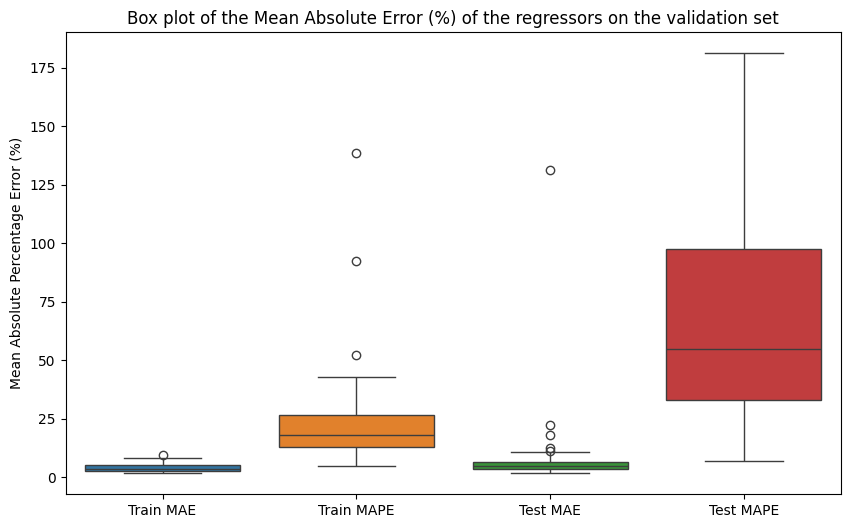

In [139]:
# Do statistics about the series regressorsMetrics_train
metrics = pd.concat([regressorsMetrics_mae_train, regressorsMetrics_mape_train, regressorsMetrics_mae_val, regressorsMetrics_mape_val], axis=1)
print((metrics*100).describe())

# box plot of the metrics
plt.figure(figsize=(10, 6))
sns.boxplot(data=metrics * 100)
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.title('Box plot of the Mean Absolute Error (%) of the regressors on the validation set')
plt.show()

## Error


In [132]:
systemsData_RelativeExpectedDailyEnergy_val_mean-systemsData_RelativeMeasuredDailyEnergy_val/np.maximum(np.abs(systemsData_RelativeExpectedDailyEnergy_val_std), 0.01)

,a001035,a001036,a001096,a001099,a001131,a001138,a001155,a001159,a001163,a001190,...,a001464,a001473,a001487,a001494,a001513,a001542,a001553,a001584,a001633,a001634
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,NaN,-3.520273,-2.586967,NaN,-1.714404,-1.107862,-2.998156,-1.980630,-2.358457,-2.177803,...,-3.376292,-1.094593,-1.606056,-0.926514,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-19,NaN,-3.413405,-3.826688,NaN,-1.276695,-1.280581,-2.214466,-1.227681,-2.486278,-1.811659,...,-3.031268,-2.204534,-1.686136,-1.561408,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-20,NaN,-12.070955,-6.739040,NaN,-5.470097,-5.177359,-8.358577,-3.030923,-6.427672,-7.597238,...,-6.777261,-1.248979,-2.524446,-2.460406,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
systemsData_RelativeDelta_val.loc[systemsData_RelativeDelta_val['a001035'].notnull(),'a001035']

Date
2024-01-14    0.938979
2024-01-15    0.483911
2024-01-16   -0.202997
2024-01-17   -0.284971
2024-01-18    0.114820
                ...   
2024-03-24   -0.028717
2024-03-25   -0.129032
2024-03-26   -0.038129
2024-03-27   -0.103223
2024-03-28   -0.010844
Name: a001035, Length: 75, dtype: float64

In [134]:
systemsData_RelativeDelta_val = (systemsData_RelativeExpectedDailyEnergy_val_mean-systemsData_RelativeMeasuredDailyEnergy_val)/np.maximum(np.abs(systemsData_RelativeExpectedDailyEnergy_val_mean), 0.01)

# eronate data are the data where the relative delta is lower than regressorsMetrics_val

systemsData_RelativeDelta_val_detected = systemsData_RelativeDelta_val[systemsData_RelativeDelta_val.loc[:, regressorsMetrics_mae_val.index] > 1.5 * regressorsMetrics_mae_val]

# Scaling technics & Outliers removal

Compute the:

- Global mean
- Global median
- Global standard deviation
- Rolling mean
- Rolling median
- Rolling standard deviation
- Simulate max production without info
- SImulated max production with info


# Plot results


In [135]:
# Initialize the Dash app
app = dash.Dash(__name__)

tab_height = '2em'
app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='system-dropdown',
            options=[{'label': name, 'value': name} for name in systemsName_Target],
            value=systemsName_Target[0],
            style={'width': '50%'}  # Adjust width and font size
        ),
        html.Div(id='metric-text-container', style={'display': 'inline-block', 'margin-left': '20px'})  # Container for the metric text
    ], style={'display': 'flex', 'align-items': 'center'}),  # Align items horizontally
    dcc.Tabs(id='plot-tabs', value='tab-energy', children=[
        dcc.Tab(label='Energy', value='tab-energy', style={'padding': '0px', 'lineHeight': tab_height}, selected_style={'padding': '0px', 'lineHeight': tab_height, 'fontWeight': 'bold'}),  # Adjust height and line height
        dcc.Tab(label='Normalizer Tuning', value='tab-norm-tuning', style={'padding': '0px', 'lineHeight': tab_height}, selected_style={'padding': '0px', 'lineHeight': tab_height, 'fontWeight': 'bold'}),  # Adjust height and line height
        dcc.Tab(label='Relative Energy', value='tab-rel-energy', style={'padding': '0px', 'lineHeight': tab_height}, selected_style={'padding': '0px', 'lineHeight': tab_height, 'fontWeight': 'bold'}),  # Adjust height and line height
        # plot systemsData_RelativeDelta_val
        dcc.Tab(label='Delta Error', value='tab-delta-rel-energy', style={'padding': '0px', 'lineHeight': tab_height}, selected_style={'padding': '0px', 'lineHeight': tab_height, 'fontWeight': 'bold'}),  # Adjust height and line height
        dcc.Tab(label='All Relative Energy', value='tab-rel-energy-all', style={'padding': '0px', 'lineHeight': tab_height}, selected_style={'padding': '0px', 'lineHeight': tab_height, 'fontWeight': 'bold'}),  # Adjust height and line height
        dcc.Tab(label='All Missing Value', value='tab-miss-val-all', style={'padding': '0px', 'lineHeight': tab_height}, selected_style={'padding': '0px', 'lineHeight': tab_height, 'fontWeight': 'bold'}),  # Adjust height and line height
        dcc.Tab(label='Similar neighboring systems', value='tab-neighbors', style={'padding': '0px', 'lineHeight': tab_height}, selected_style={'padding': '0px', 'lineHeight': tab_height, 'fontWeight': 'bold'}),  # Adjust height and line height

    ]),  # Adjust height for tabs
    html.Div(id='tabs-content', style={'flex': '1 1 auto'})  # Allow the tabs-content div to grow
], style={'display': 'flex', 'flexDirection': 'column', 'height': '100vh'})  # Make the outer container fill the screen height


@app.callback(
    [Output('tabs-content', 'children'),
     Output('metric-text-container', 'children')],
    [Input('plot-tabs', 'value'),
     Input('system-dropdown', 'value')]
)
def render_content(tab, selected_system):
    # Statistic text
    try:
        mae_train = regressorsMetrics_mae_train.loc[selected_system]
    except:
        mae_train = np.nan
    try:
        mae_val = regressorsMetrics_mae_val.loc[selected_system]
    except:
        mae_val = np.nan
    try:
        loss = systemsMetadata[selected_system]['metadata']['loss']
    except:
        loss = np.nan

    mae_train_text = f"Estimator Train Error : {mae_train * 100:.2f}%"
    mae_test_text = f"Estimator Test Error  : {mae_val * 100:.2f}%"
    loss_text = f"System Loss   : {loss * 100:.2f}%"

    metric_text_div = html.Div([
        html.Div(mae_train_text),
        html.Div(mae_test_text),
        html.Div(loss_text)
    ], style={'fontSize': 16})

    if tab == 'tab-energy':
        fig1 = go.Figure(layout_yaxis_title="Daily Energy (kWh)")

        # remove nan from systemsData_EstimatedMaxDailyEnergy[selected_system]

        try:
            estimatedMaxDailyEnergy = systemsData_EstimatedMaxDailyEnergy[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=estimatedMaxDailyEnergy.index,
                y=estimatedMaxDailyEnergy,
                mode='markers',
                name='Estimated Max Daily Energy',
                marker_color='LightSeaGreen'
            ))
        except:
            pass

        try:
            measuredDailyEnergy = systemsData_MeasuredDailyEnergy[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=measuredDailyEnergy.index,
                y=measuredDailyEnergy,
                mode='markers',
                name='Measured Daily Energy',
                marker_color='blue'
            ))
        except:
            pass

        # try:
        # measuredDailyEnergy_train_outliers = systemsData_MeasuredDailyEnergy_train_outliers[selected_system].dropna()
        #     fig1.add_trace(go.Scatter(
        #         x=measuredDailyEnergy_train_outliers.index,
        #         y=measuredDailyEnergy_train_outliers,
        #         mode='markers',
        #         name='Outliers',
        #         marker_color='yellow'
        #     ))
        # except:
        #     pass
        # try:
        #     expectedDailyEnergy_train = systemsData_ExpectedDailyEnergy_train[selected_system].dropna()
        #     fig1.add_trace(go.Scatter(
        #         x=expectedDailyEnergy_train.index,
        #         y=expectedDailyEnergy_train,
        #         mode='markers',
        #         name='Expected Daily Energy',
        #         marker_color='red'
        #     ))
        # except:
        #     pass

        try:
            expectedDailyEnergy_val_mean = systemsData_ExpectedDailyEnergy_val_mean[selected_system].dropna()
            expectedDailyEnergy_val_std = systemsData_ExpectedDailyEnergy_val_std[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=expectedDailyEnergy_val_mean.index,
                y=expectedDailyEnergy_val_mean,
                mode='markers',
                name='Expected Daily Energy',
                marker_color='red'
                # error_y=dict(
                #     type='data',
                #     array=expectedDailyEnergy_val_std,
                #     visible=True
                # )
            ))
        except:
            pass

        # Update layout for legend position
        fig1.update_layout(
            legend=dict(
                x=0.99,
                y=0.99,
                xanchor='right',
                yanchor='top',
                orientation='h'
            )
        )

        return dcc.Graph(figure=fig1, style={'height': '100%', 'width': '100%'}), metric_text_div  # Adjust height and width of the figure

    elif tab == 'tab-norm-tuning':
        fig1 = go.Figure(layout_yaxis_title="Daily Energy (kWh)")
        try:
            measuredDailyEnergy = systemsData_MeasuredDailyEnergy[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=measuredDailyEnergy.index,
                y=measuredDailyEnergy,
                mode='markers',
                name='Measured Daily Energy',
                marker_color='blue'
            ))
        except:
            pass
        try:
            measuredMax = systemsData_Tuning_MeasureMax[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=measuredMax.index,
                y=measuredMax,
                mode='markers',
                name='Max Measured Daily Energy (7 days)',
                marker_color='red'
            ))
        except:
            pass
        try:
            outliers = systemsData_Tuning_Outliers[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=outliers.index,
                y=outliers,
                mode='markers',
                name='Tuning Outliers',
                marker_color='yellow'
            ))
        except:
            pass
        try:
            estimatedMaxDailyEnergy_untuned = systemsData_Tuning_EstimatedMaxDailyEnergy_untuned[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=estimatedMaxDailyEnergy_untuned.index,
                y=estimatedMaxDailyEnergy_untuned,
                mode='markers',
                name='Estimated Max Daily Energy (Untuned)',
                marker_color='violet'
            ))
        except:
            pass
        try:
            estimatedMaxDailyEnergy = systemsData_EstimatedMaxDailyEnergy[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=estimatedMaxDailyEnergy.index,
                y=estimatedMaxDailyEnergy,
                mode='markers',
                name='Estimated Max Daily Energy',
                marker_color='LightSeaGreen'
            ))
        except:
            pass

        fig1.update_layout(
            legend=dict(
                x=0.99,
                y=0.99,
                xanchor='right',
                yanchor='top',
                orientation='h'
            )
        )

        return dcc.Graph(figure=fig1, style={'height': '100%', 'width': '100%'}), metric_text_div
    elif tab == 'tab-rel-energy':
        fig1 = go.Figure(layout_yaxis_title="Proportional Daily Energy (%)")
        # add a line at 100% for the Estimated Max Daily Energy
        estimatedMaxDailyEnergy = systemsData_EstimatedMaxDailyEnergy[selected_system].dropna()
        fig1.add_shape(
            type="line",
            x0=estimatedMaxDailyEnergy.index.min(),
            y0=100,
            x1=estimatedMaxDailyEnergy.index.max(),
            y1=100,
            name='Estimated Max Daily Energy',
            line_color='LightSeaGreen'
            # line=dict(
            #     color="LightSeaGreen",
            #     width=2,
            #     dash="dashdot",
            # ),
        )
        try:
            relativeMeasuredDailyEnergy = systemsData_RelativeMeasuredDailyEnergy[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=relativeMeasuredDailyEnergy.index,
                y=relativeMeasuredDailyEnergy * 100,
                mode='markers',
                name='Measured Daily Energy',
                marker_color='blue'
            ))
        except:
            pass
        try:
            relativeExpectedDailyEnergy_val_mean = systemsData_RelativeExpectedDailyEnergy_val_mean[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=relativeExpectedDailyEnergy_val_mean.index,
                y=relativeExpectedDailyEnergy_val_mean * 100,
                mode='markers',
                name='Expected Daily Energy',
                marker_color='red'
                # error_y=dict(
                #     type='data',
                #     array=systemsData_RelativeExpectedDailyEnergy_val_std[selected_system] * 100,
                #     visible=True
                # )
            ))
        except:
            pass

        return dcc.Graph(figure=fig1, style={'height': '100%', 'width': '100%'}), metric_text_div  # Adjust height and width of the figure
    elif tab == 'tab-delta-rel-energy':
        fig1 = go.Figure(layout_yaxis_title="Proportional Daily Energy Error(%)")
        try:
            relativeDelta_val = systemsData_RelativeDelta_val[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=relativeDelta_val.index,
                y=relativeDelta_val * 100,
                mode='markers',
                name='Relative Delta Energy',
            ))
        except:
            pass
        try:
            relativeDelta_val_detected = systemsData_RelativeDelta_val_detected[selected_system].dropna()
            fig1.add_trace(go.Scatter(
                x=relativeDelta_val_detected.index,
                y=relativeDelta_val_detected * 100,
                mode='markers',
                name='Detected Errors',
                marker_color='red'
            ))
        except:
            pass

        return dcc.Graph(figure=fig1, style={'height': '100%', 'width': '100%'}), metric_text_div  # Adjust height and width of the figure
    elif tab == 'tab-rel-energy-all':
        fig1 = go.Figure(layout_yaxis_title="Proportional Daily Energy (%)")
        # try:
        features_importance_norm = features_importance_df.loc[selected_system]/features_importance_df.loc[selected_system].max()

        for systemName in systemsName_Target:
            if systemName != selected_system:
                if features_importance_norm[systemName] > 0.1:
                    fig1.add_trace(go.Scatter(
                        x=systemsData_RelativeMeasuredDailyEnergy[systemName].index,
                        y=systemsData_RelativeMeasuredDailyEnergy[systemName] * 100,
                        mode='markers',
                        name=f'{systemName}',
                        marker_color='blue',
                        marker_opacity=features_importance_norm[systemName]
                    ))
        fig1.add_trace(go.Scatter(
            x=systemsData_RelativeMeasuredDailyEnergy[selected_system].index,
            y=systemsData_RelativeMeasuredDailyEnergy[selected_system] * 100,
            mode='markers',
            name=f'{selected_system}',
            marker_color='red'
        ))
        fig1.update_layout(yaxis=dict(range=[-5, 120]))

        # except:
        #     pass

        return dcc.Graph(figure=fig1, style={'height': '100%', 'width': '100%'}), metric_text_div  # Adjust height and width of the figure
    elif tab == 'tab-miss-val-all':
        missing_values = (~systemsData_MeasuredDailyEnergy.isnull()).astype(int)

        fig = go.Figure(data=go.Heatmap(
            z=missing_values,
            x=missing_values.columns,
            y=missing_values.index,
            showscale=False,
            colorscale='Greys'  # Set colorscale to black and white
        ))
        fig.update_layout(
            yaxis=dict(showticklabels=True),  # Hide y-axis tick labels
            yaxis_tickmode='array',
            yaxis_tickvals=pd.date_range(start=missing_values.index.min(), end=missing_values.index.max(), freq='ME'),
            yaxis_ticktext=pd.date_range(start=missing_values.index.min(), end=missing_values.index.max(), freq='ME').strftime('%b %Y')
        )

        return dcc.Graph(figure=fig, style={'height': '100%', 'width': '100%'}), metric_text_div  # Adjust height and width of the figure

    elif tab == 'tab-neighbors':
        fig2 = go.Figure()

        # Add initial traces with secondary y-axis
        try:
            fig2.add_trace(go.Bar(
                x=features_importance_df.columns,
                y=features_importance_df.loc[selected_system],
                name='Impurity-based Importance',
                yaxis='y1',
                offsetgroup=1
            ))
            fig2.update_layout(
                yaxis1=dict(
                    title='Impurity-based Importance',
                    range=[0, features_importance_df.loc[selected_system].max()],
                )
            )
        except:
            pass
        try:
            fig2.add_trace(go.Bar(
                x=permutation_importance_mean_df.columns,
                y=permutation_importance_mean_df.loc[selected_system],
                name='Permutation Importance',
                yaxis='y2',
                offsetgroup=2
            ))
            fig2.update_layout(
                yaxis2=dict(
                    title='Permutation Importance',
                    overlaying='y',
                    side='right',
                    range=[0, permutation_importance_mean_df.loc[selected_system].max()],
                )
            )
        except:
            pass

        return dcc.Graph(figure=fig2, style={'height': '100%', 'width': '100%'}), metric_text_div  # Adjust height and width of the figure


def open_browser():
    webbrowser.open("http://127.0.0.1:8050/")


if __name__ == '__main__':
    # Open the Dash app in a new browser window
    Timer(1, open_browser).start()
    app.run_server(debug=True, use_reloader=False)

## Interpreting result from a prediction

https://towardsdatascience.com/interpreting-random-forests-638bca8b49ea
